In [1]:
#import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import metpy.calc as mpcalc
from metpy.plots import SkewT, Hodograph
from metpy.units import units

from datetime import datetime

In [2]:
# date, time and station of sounding to be plotted
year = 2022
month = 12
day = 27
hour = 0

station = "KOAK"

#get data from Iowa Environmental Mesonet (IEM) RAOB archive

#convert date and time to datetime object
dt = datetime(year=year,month=month,day=day,hour=hour)

#convert datetime object to string to add into the IEM url
t = dt.strftime('%Y%m%d%H%M')

#define the url
url = f"https://mesonet.agron.iastate.edu/json/raob.py?ts={t}&station={station}"

#read the json sounding data using pandas
json = pd.read_json(url)

#convert the json sounding to a pandas dataframe
df = pd.json_normalize(json.profiles[0],'profile',['station','valid'])

#convert the "valid" variable to a datetime object
df['valid'] = pd.to_datetime(df['valid'])
#print(df)

In [3]:
### create a new dataframe for just temperature and dewpoint ###

#first remove any rows where there is no data
df_temp = df.dropna(subset=['tmpc','dwpc'])
#print(df_temp)
#print()
#next just keep pressure, height, temperature, and dewpoint
df_temp_new = df_temp[['pres','hght','tmpc','dwpc']]

#print(df_temp_new)
### create a new dataframe for just winds ###

#first remove any rows where there is no data
df_wind = df.dropna(subset=['sknt','drct'])
#next just keep pressure, height, temperature, and dewpoint
df_wind_new = df_temp[['pres','hght','sknt','drct']]
#print()
#print(df_wind_new)

pressure = np.array(df_temp_new['pres']) * units('millibars')
height = np.array(df_temp_new['hght']) * units('meters')
temperature = np.array(df_temp_new['tmpc']) * units('degC')
dewpoint = np.array(df_temp_new['dwpc']) * units('degC')
#print(dewpoint)

wind_pressure = np.array(df_wind_new['pres']) * units('millibars')
wind_height = np.array(df_wind_new['hght']) * units('meters')
wind_speed = np.array(df_wind_new['sknt']) * units('knots')
wind_direction = np.array(df_wind_new['drct']) * units('degrees')
#print(wind_speed)

u,v = mpcalc.wind_components(wind_speed,wind_direction)
#print(u)
#print()
#print(v)

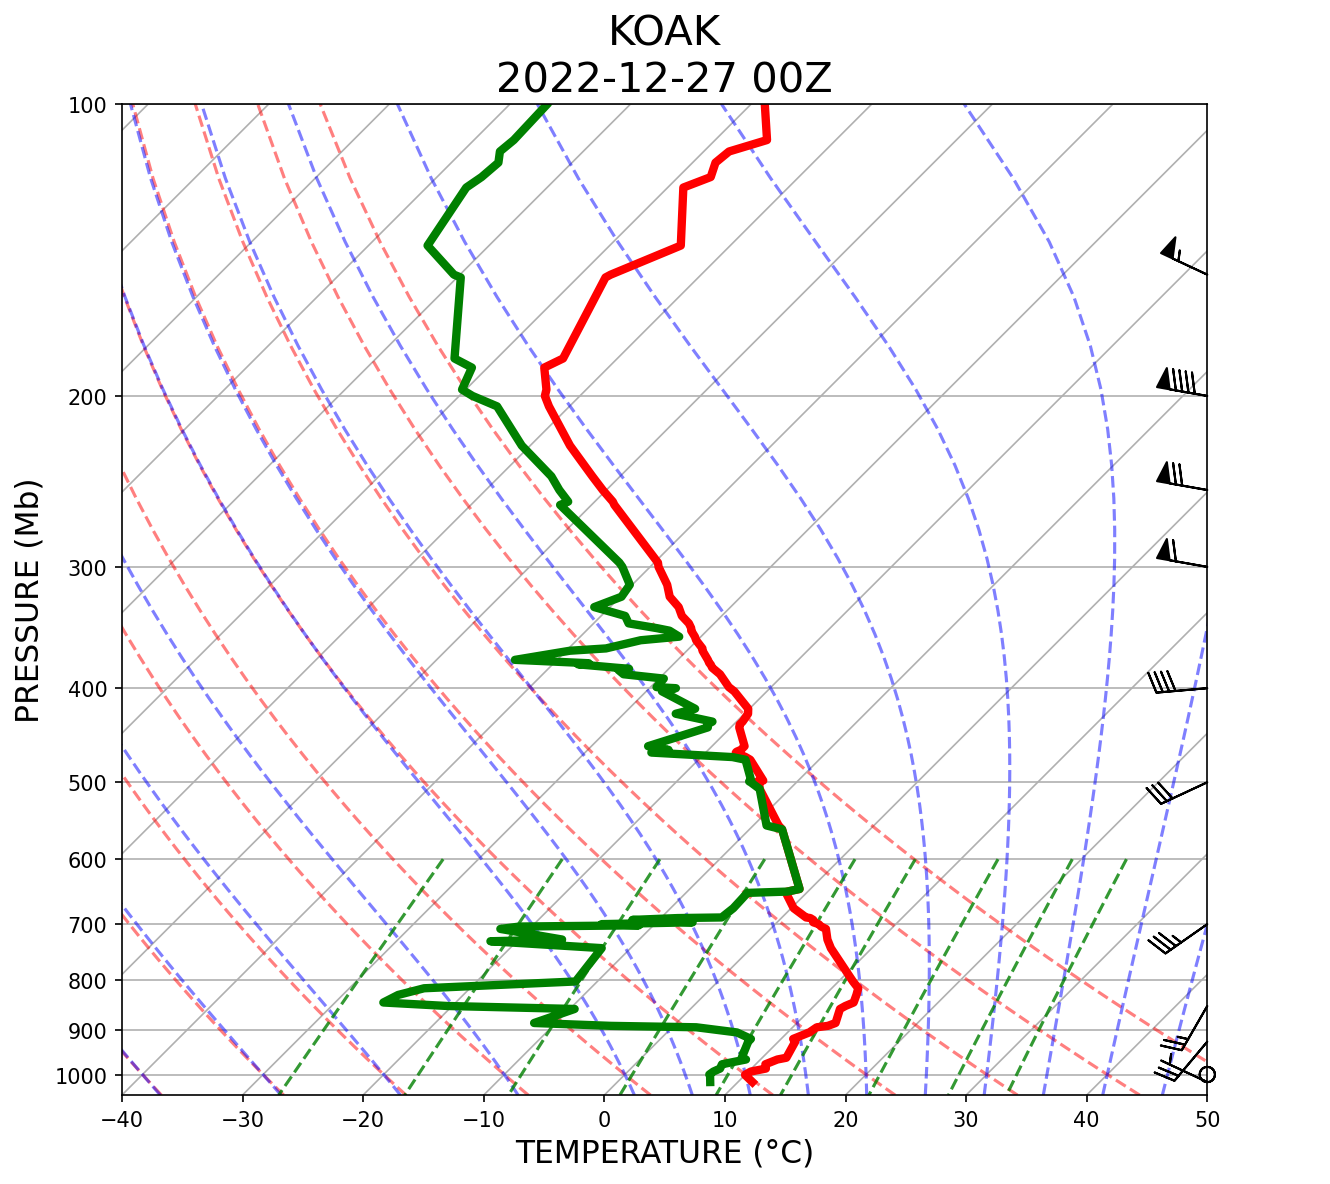

In [5]:
#create skew-t figure
fig = plt.figure(figsize=(11, 8), dpi=150,facecolor='w')
skew = SkewT(fig, rotation=45)

#plot temperature in red and dewpoint in green
skew.plot(pressure, temperature, 'r',lw=4)
skew.plot(pressure, dewpoint, 'g',lw=4)

#create axes labels
plt.xlabel('TEMPERATURE (\N{degree sign}C)',fontsize=15)
plt.ylabel('PRESSURE (Mb)',fontsize=15)

#add in typical lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

#plot winds 
skew.plot_barbs(pressure, u, v, y_clip_radius=0)

#Parcel Profile and defining profile
prof = mpcalc.parcel_profile(pressure, temperature[1], dewpoint[1]).to('degC')

#plotting CAPE and CIN
skew.shade_cin(pressure, temperature, prof, dewpoint)
skew.shade_cape(pressure, temperature, prof)

#add title for date and location
plt.title(f'{station}\n%04i-%02i-%02i %02iZ'%(year,month,day,hour), fontsize=20)

#save figure
fig.tight_layout()
plt.savefig(f'{station}_%04i%02i%02i_%02i.png'%(year,month,day,hour))